# **KomuterPulse Model Development: XGBoost for Ridership Prediction**

This notebook focuses on developing machine learning models for our KomuterPulse project, with special emphasis on XGBoost for ridership prediction. The model will leverage engineered features from our KTM Komuter transit data to forecast hourly ridership between station pairs.

### **Objectives**
1. Load and prepare the feature-engineered data
2. Build and train XGBoost models
3. Hyperparameter Tuning
4. Blend XGBoost, LightGBM, and RandomForest Predictions

In [22]:
!pip install optuna --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from pathlib import Path
from datetime import datetime
import time
import xgboost as xgb
import optuna

# For data preprocessing and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb


# For visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Set random seeds for reproducibility
np.random.seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## **Data Loading and Preparation**

In [23]:
# Mount Google Drive first
from google.colab import drive
drive.mount('/content/drive')

# Define paths for Google Drive
DATA_DIR = Path('/content/drive/MyDrive/Komuter Data Processed')
train_path = DATA_DIR / 'komuter_train.csv'
test_path = DATA_DIR / 'komuter_test.csv'
feature_subsets_path = Path('/content/drive/MyDrive/feature_subsets.pkl')


# Load data
try:
    # Load training and testing data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Training data loaded: {train_df.shape}")
    print(f"Testing data loaded: {test_df.shape}")

    # Load feature subsets
    with open(feature_subsets_path, 'rb') as f:
        feature_subsets = pickle.load(f)
    print("Feature subsets loaded successfully.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the data files are in the correct location in Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data loaded: (537642, 55)
Testing data loaded: (132957, 55)
Feature subsets loaded successfully.


In [24]:
# Display the available feature subsets and their sizes
for subset_name, features in feature_subsets.items():
    if isinstance(features, list):
        print(f"{subset_name}: {len(features)} features")
    else:
        print(f"{subset_name}: {features}")

# We'll use the consensus features identified from our feature engineering notebook
selected_features = feature_subsets['consensus_features']
print(f"\nSelected features for XGBoost model ({len(selected_features)} features):")
print(selected_features)

all_features: 53 features
consensus_features: 18 features
rf_top_features: 15 features
xgb_top_features: 15 features
selectkbest_features: 20 features
pca_n_components: 19

Selected features for XGBoost model (18 features):
['avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h', 'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d', 'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h', 'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h']


## **Feature Preparation and Target Creation**

In [25]:
# Create the target variable by shifting total ridership by -1 hour for each OD pair
train_df['target'] = train_df.groupby(['origin', 'destination'])['total_ridership'].shift(-1)
test_df['target'] = test_df.groupby(['origin', 'destination'])['total_ridership'].shift(-1)

# Drop NA values resulting from the shift
train_df.dropna(subset=['target'], inplace=True)
test_df.dropna(subset=['target'], inplace=True)

In [26]:
features = [
    'avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h',
    'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d',
    'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h',
    'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h',
    'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h'
]

## **Train XGBoost Model**

In [27]:
# Prepare DMatrix
dtrain = xgb.DMatrix(train_df[features], label=train_df['target'])
dtest = xgb.DMatrix(test_df[features], label=test_df['target'])

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=1000,
                  evals=[(dtrain, 'train')],
                  early_stopping_rounds=30,
                  verbose_eval=50)

[0]	train-rmse:10.77870
[50]	train-rmse:6.75809
[100]	train-rmse:6.53375
[150]	train-rmse:6.36866
[200]	train-rmse:6.23204
[250]	train-rmse:6.12923
[300]	train-rmse:6.03333
[350]	train-rmse:5.94794
[400]	train-rmse:5.86999
[450]	train-rmse:5.79777
[500]	train-rmse:5.72689
[550]	train-rmse:5.66362
[600]	train-rmse:5.60507
[650]	train-rmse:5.54596
[700]	train-rmse:5.49366
[750]	train-rmse:5.44042
[800]	train-rmse:5.39009
[850]	train-rmse:5.34367
[900]	train-rmse:5.29799
[950]	train-rmse:5.25750
[999]	train-rmse:5.21332


In [28]:
# Make predictions with your trained model
dtest = xgb.DMatrix(test_df[features])
preds = model.predict(dtest)

y_true = test_df['target']
y_pred = preds

# Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

MSE:  45.07
RMSE: 6.71
MAE:  3.00
R²:   0.5739


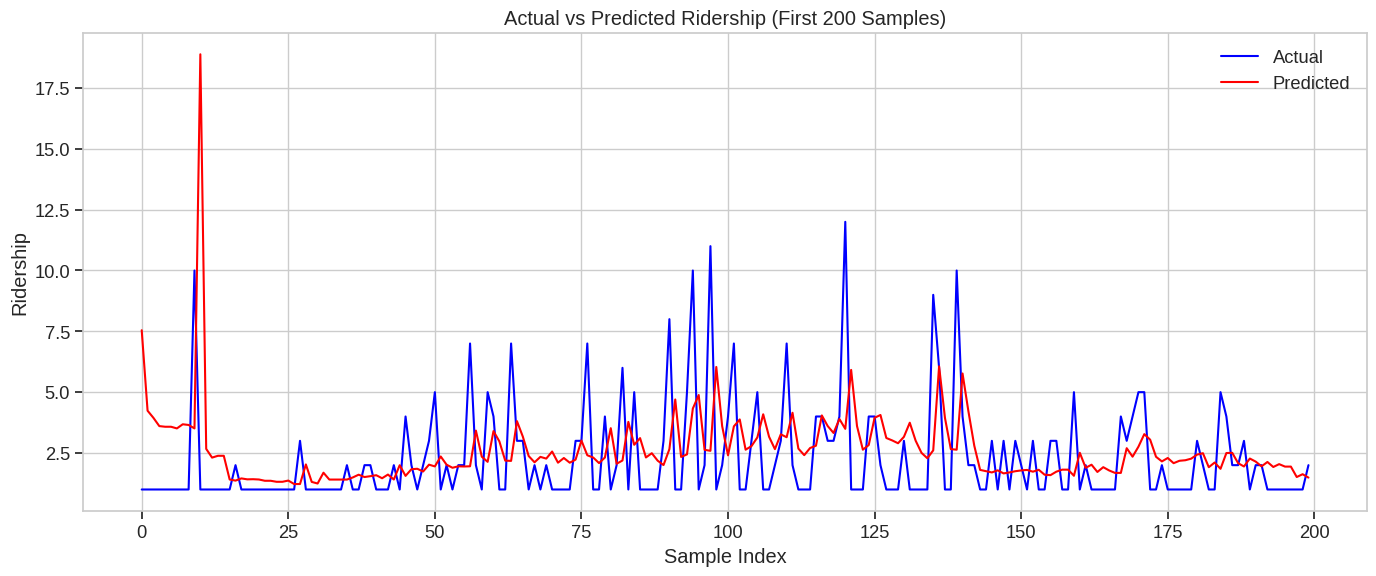

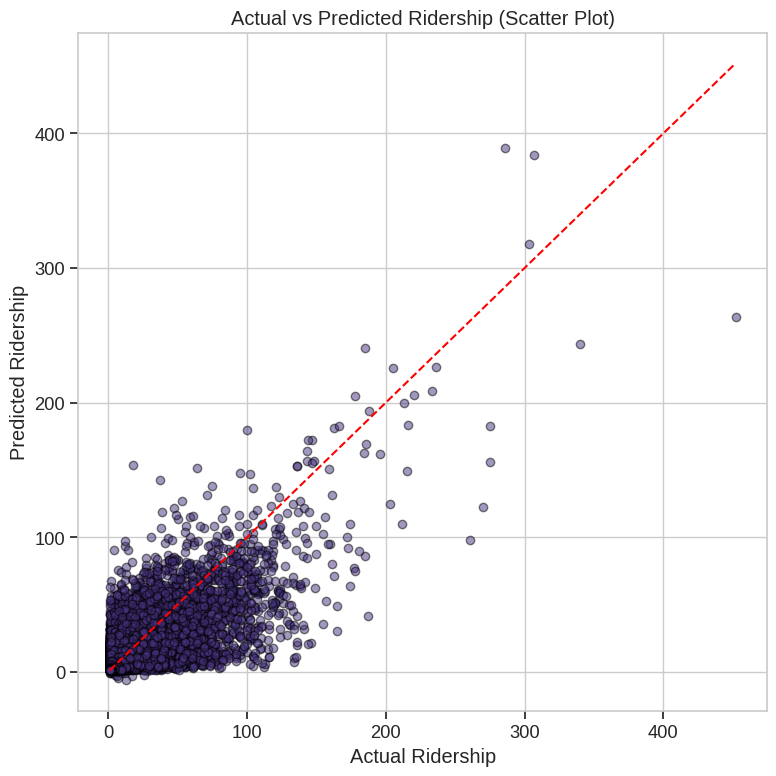

In [29]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_true.values[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)
plt.tight_layout()
plt.show()



## **Hyperparameter Tuning**

In [30]:
# Split training into train/val for tuning
train_data = train_df.sample(frac=0.8, random_state=42)
val_data = train_df.drop(train_data.index)

dtrain = xgb.DMatrix(train_data[features], label=train_data['target'])
dval = xgb.DMatrix(val_data[features], label=val_data['target'])

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 0.1, 5.0),  # L2
        'alpha': trial.suggest_float('alpha', 0.0, 5.0),    # L1
        'seed': 42
    }

    model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=[(dval, 'validation')],
                      early_stopping_rounds=30,
                      verbose_eval=False)

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(val_data['target'], preds))
    return rmse

In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Try 50 different combinations

[I 2025-05-10 18:48:56,977] A new study created in memory with name: no-name-179b52c1-db8d-48f6-8599-2a5a778b5cc6
[I 2025-05-10 18:49:05,096] Trial 0 finished with value: 7.247076575212031 and parameters: {'max_depth': 5, 'eta': 0.2877585157685548, 'subsample': 0.9595520517957821, 'colsample_bytree': 0.7237323792322499, 'min_child_weight': 2, 'lambda': 1.2739596595906992, 'alpha': 4.162691537124659}. Best is trial 0 with value: 7.247076575212031.
[I 2025-05-10 18:49:53,972] Trial 1 finished with value: 7.10535877310488 and parameters: {'max_depth': 10, 'eta': 0.012755789296097974, 'subsample': 0.8049456980497569, 'colsample_bytree': 0.9641588808839289, 'min_child_weight': 2, 'lambda': 1.5525133575966383, 'alpha': 2.96622270029006}. Best is trial 1 with value: 7.10535877310488.
[I 2025-05-10 18:49:56,334] Trial 2 finished with value: 7.214020680637927 and parameters: {'max_depth': 9, 'eta': 0.24179941110101555, 'subsample': 0.8566049040512891, 'colsample_bytree': 0.6576624073076602, 'mi

In [32]:
print("Best trial:")
print(f"  RMSE: {study.best_value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 7.0695
  Best hyperparameters:
    max_depth: 9
    eta: 0.019634434244008007
    subsample: 0.9398333007743064
    colsample_bytree: 0.6801209774741854
    min_child_weight: 4
    lambda: 0.4060763268667211
    alpha: 2.817334935611895


In [33]:
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'

dtrain_full = xgb.DMatrix(train_df[features], label=train_df['target'])
dtest = xgb.DMatrix(test_df[features], label=test_df['target'])

model_optuna = xgb.train(best_params, dtrain_full, num_boost_round=1000,
                  evals=[(dtrain_full, 'train')],
                  early_stopping_rounds=30, verbose_eval=50)

[0]	train-rmse:11.26419
[50]	train-rmse:7.63442
[100]	train-rmse:6.67025
[150]	train-rmse:6.35563
[200]	train-rmse:6.18912
[250]	train-rmse:6.08420
[300]	train-rmse:5.99842
[350]	train-rmse:5.93031
[400]	train-rmse:5.86959
[450]	train-rmse:5.81249
[500]	train-rmse:5.75899
[550]	train-rmse:5.70993
[600]	train-rmse:5.65509
[650]	train-rmse:5.60934
[700]	train-rmse:5.56516
[750]	train-rmse:5.52333
[800]	train-rmse:5.48205
[850]	train-rmse:5.44062
[900]	train-rmse:5.40282
[950]	train-rmse:5.36351
[999]	train-rmse:5.32765


In [34]:
# Make predictions with your trained model
dtest = xgb.DMatrix(test_df[features])
preds = model_optuna.predict(dtest)

y_true = test_df['target']
y_pred = preds

# Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

MSE:  43.37
RMSE: 6.59
MAE:  2.97
R²:   0.5900


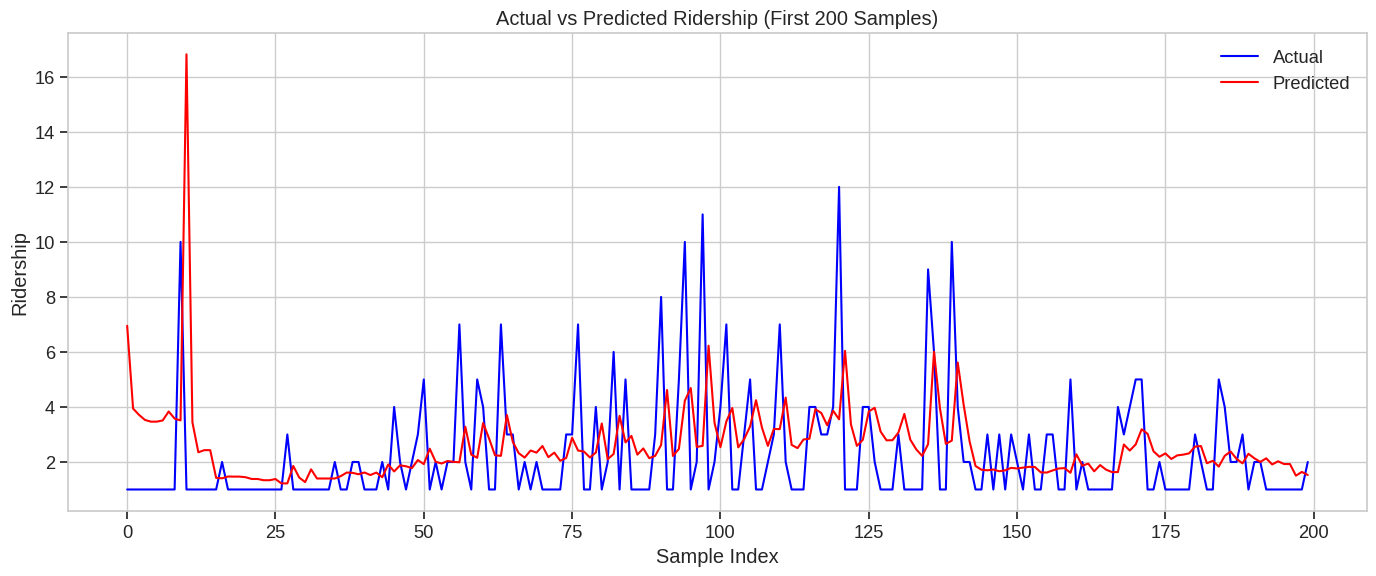

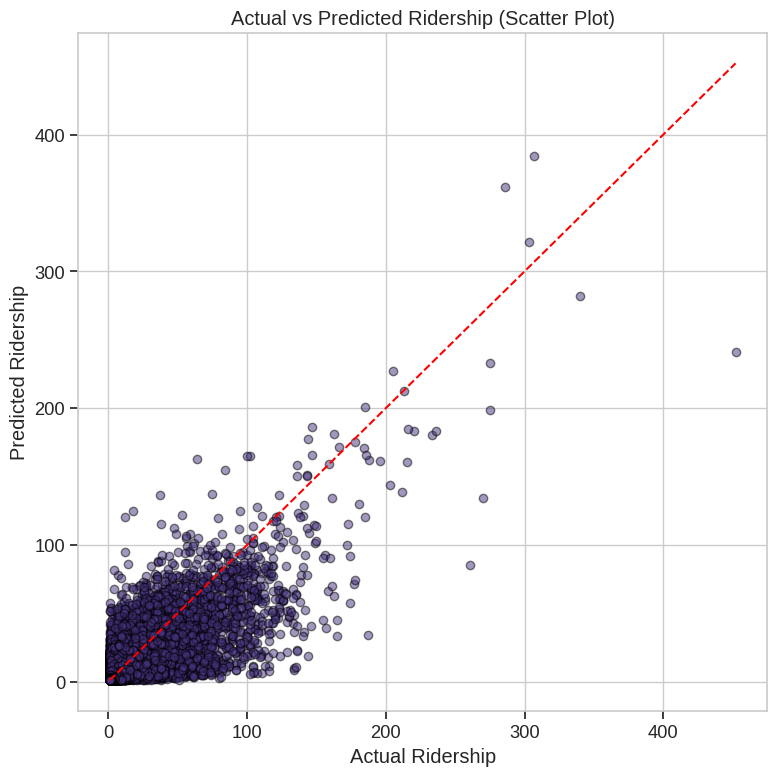

In [35]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_true.values[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Blend XGBoost, LightGBM, and RandomForest Predictions**

In [36]:
# Train each model
# 1. XGBoost
dtrain = xgb.DMatrix(train_df[features], label=train_df['target'])
dtest = xgb.DMatrix(test_df[features])

xgb_model = xgb.train(best_params, dtrain, num_boost_round=300)
xgb_preds = xgb_model.predict(dtest)

# 2. LightGBM
lgb_model = lgb.LGBMRegressor(**{
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
})
lgb_model.fit(train_df[features], train_df['target'])
lgb_preds = lgb_model.predict(test_df[features])

# 3. RandomForest
rf_model = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(train_df[features], train_df['target'])
rf_preds = rf_model.predict(test_df[features])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3948
[LightGBM] [Info] Number of data points in the train set: 534412, number of used features: 18
[LightGBM] [Info] Start training from score 4.834783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [37]:
# Blend predictions
ensemble_preds = (xgb_preds + lgb_preds + rf_preds) / 3

In [38]:
y_true = test_df['target']
mse = mean_squared_error(y_true, ensemble_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, ensemble_preds)
r2 = r2_score(y_true, ensemble_preds)

print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

MSE:  42.93
RMSE: 6.55
MAE:  2.97
R²:   0.5942


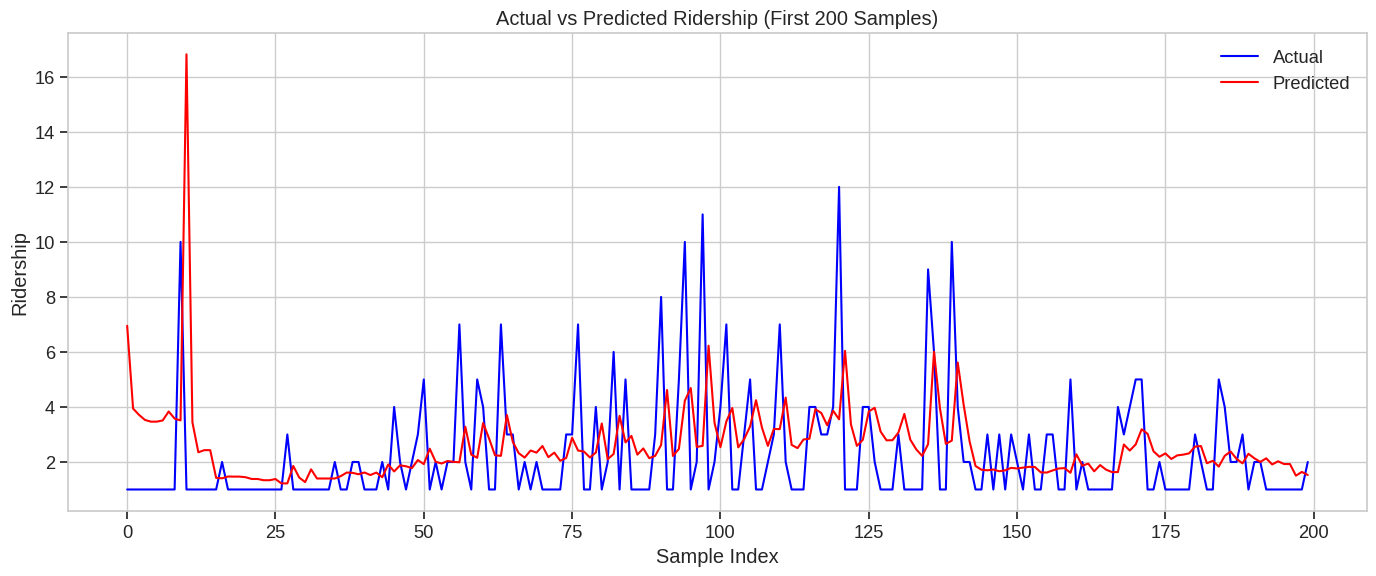

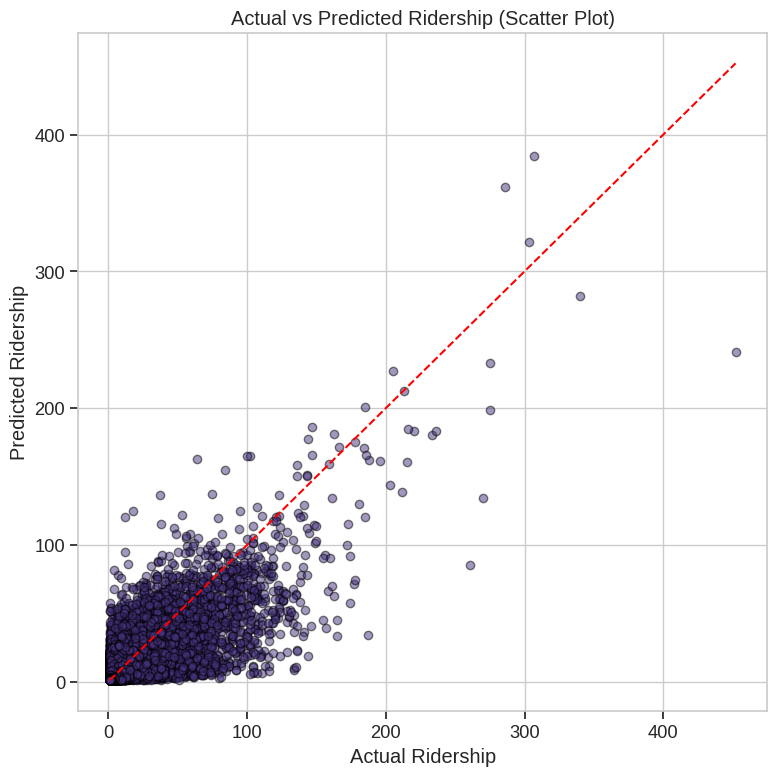

In [39]:
# Visualize predictions vs actual values
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_true.values[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)
plt.tight_layout()
plt.show()